# Federated Learning with Pytorch Backend

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.

In this tutorial, We will walk you through how to use pytorch backend on SecretFlow for federated learning.  

+ We will use the image clasification task as example
+ Use pytorch as backend
+ We will show how to use multi fl strategy
  
If you want to learn more about federated learning, datasets, etc., you can move to [Federated Learning for Image Classification](Federate_Learning_for_Image_Classification.ipynb).
  
**Here we go!**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.7.0b0


/home/beng003/anaconda/envs/sf_1.7/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-01 18:24:25,742	INFO worker.py:1724 -- Started a local Ray instance.


(raylet) [2024-08-01 18:25:25,664 E 1476144 1476144] (raylet) node_manager.cc:3024: 5 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 08dc03f2588dbb8c9d93d512cfda5a1b6d74f3f4438b1170e4d22081, IP: 10.0.0.3) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.0.0.3`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2024-08-01 18:26:25,666 E 1476144 1476144] (raylet) node_manager.cc:3024: 1 Workers (tasks / actors) killed due

### Here, let us first introduce some concepts
BaseModule: Similar to the `torch.nn.module`.    
TorchModel: A wrap class include `loss_fn`,`optim_fn`,`model_def`,`metrics`.  
metric_wrapper: Wrap metrics to workers.  
optim_wrapper: Wrap optim_fn to workers.  
FLModel: Federated model, use `backend` to specify which bachend will be use, use `strategy` to spcify which federated strategy will be use.

In [3]:
from secretflow.ml.nn.core.torch import (
    metric_wrapper,
    optim_wrapper,
    BaseModule,
    TorchModel,
)
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F

When we define the model, we only need to inherit `BaseModule` instead of `nn.Module`, and the others are consistent with pytorch.

In [4]:
class ConvNet(BaseModule):
    """Small ConvNet for MNIST."""

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc_in_dim = 192
        self.fc = nn.Linear(self.fc_in_dim, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.fc_in_dim)
        x = self.fc(x)
        return F.softmax(x, dim=1)

We can continue to use the loss function and optimizer defined in pytorch, the only difference is that we need to wrap it with the wrapper provided in secretflow.

In [5]:
(train_data, train_label), (test_data, test_label) = load_mnist(
    parts={alice: 0.4, bob: 0.6},
    normalized_x=True,
    categorical_y=True,
    is_torch=True,
)

train_data=train_data[0:10]
train_label=train_label[0:10]


loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)
model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)

In [6]:
device_list = [alice, bob]
server = charlie
aggregator = SecureAggregator(server, [alice, bob])

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy='fed_avg_w',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [7]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=3,
    batch_size=3,
    aggregate_freq=1,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f601a739750>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f601a739f90>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f601a7394e0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f601b0390f0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 3, 'batch_sampling_rate': None, 'epochs': 3, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f601a738cd0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f601a739000>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f601a

Train Processing: :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/3


Train Processing: :   0%|          | 0/4 [00:00<?, ?it/s]/home/beng003/anaconda/envs/sf_1.7/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

(PYUFedAvgW pid=1476859) /home/beng003/anaconda/envs/sf_1.7/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(PYUFedAvgW pid=14

Epoch 2/3


(PYUFedAvgW pid=1476859) {'train-loss': 2.316336154937744, 'train_multiclassaccuracy': tensor(0.), 'train_multiclassprecision': tensor(0.), 'val_eval_multiclassaccuracy': tensor(0.0930), 'val_eval_multiclassprecision': tensor(0.0930)}


Train Processing: :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/3


Train Processing: :  75%|███████▌  | 3/4 [00:01<00:00,  1.84it/s, {'multiclassaccuracy': 0.25, 'multiclassprecision': 0.25, 'val_multiclassaccuracy': 0.15952286, 'val_multiclassprecision': 0.15952286}]


In [9]:
history

{'global_history': {'multiclassaccuracy': [0.05, 0.15, 0.25],
  'multiclassprecision': [0.05, 0.15, 0.25],
  'val_multiclassaccuracy': [0.08979085, 0.08979085, 0.15952286],
  'val_multiclassprecision': [0.08979085, 0.08979085, 0.15952286]},
 'local_history': {'alice_train-loss': [2.316336154937744,
   2.315725088119507,
   2.3243913650512695],
  'alice_train_multiclassaccuracy': [tensor(0.),
   tensor(0.1000),
   tensor(0.1000)],
  'alice_train_multiclassprecision': [tensor(0.),
   tensor(0.1000),
   tensor(0.1000)],
  'alice_val_eval_multiclassaccuracy': [tensor(0.0930),
   tensor(0.0930),
   tensor(0.1605)],
  'alice_val_eval_multiclassprecision': [tensor(0.0930),
   tensor(0.0930),
   tensor(0.1605)],
  'bob_train-loss': [2.3093550205230713, 2.231449842453003, 2.053985357284546],
  'bob_train_multiclassaccuracy': [tensor(0.1000),
   tensor(0.2000),
   tensor(0.4000)],
  'bob_train_multiclassprecision': [tensor(0.1000),
   tensor(0.2000),
   tensor(0.4000)],
  'bob_val_eval_multiclas

INFO:matplotlib.font_manager:generated new fontManager


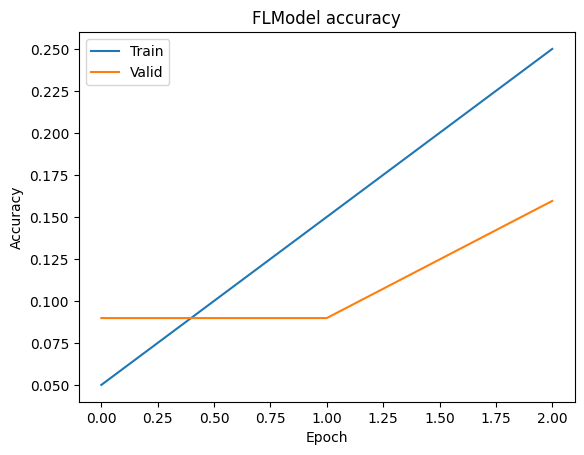

In [8]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]['multiclassaccuracy'])
plt.plot(history["global_history"]['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()